# Initial Setup

In [69]:
# Importing necessary libraries
import pandas as pd
import numpy as np      
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import classification_report,confusion_matrix

# Suppressing warnings
warnings.filterwarnings("ignore")

# Setting the style for seaborn
sns.set_theme(style="whitegrid")

# Display full column content and all columns
pd.set_option('display.max_columns', None)        # Show all columns
pd.set_option('display.max_colwidth', None)       # Don't truncate column text
pd.set_option('display.expand_frame_repr', True)  # Prevent column wrapping
pd.set_option('display.float_format', '{:,.3f}'.format)

In [70]:
#loading the dataset
data = pd.read_csv('../data/merged_output.csv')
# df.head(10)   

In [71]:
# cretating a copy of the dataframe to avoid modifying the original data
df = data.copy()


# EDA

In [88]:
df.head(5)

,image_url,labeller1_label,labeller2_label,model_a_too_dark,model_a_blur,model_a_normal_image_quality,model_b_too_dark,model_b_blur,model_b_normal_image_quality,agreement,ambiguous,prob_sum_a,prob_sum_b,ground_truth
0,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/4e58f149-1c8d-4159-9e6f-614dec04cced.jpg,normal,normal,0.004,0.871,0.301,0.008,0.005,0.986,True,False,1.176,0.999,normal
1,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/35f6e863-9728-448e-8ce2-d94d2d24b028.jpg,normal,normal,0.007,0.010,0.994,0.008,0.011,0.989,True,False,1.011,1.009,normal
2,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/9453c99f-a213-46f5-b58e-601aa7a69cfe.jpg,normal,normal,0.004,0.111,0.933,0.006,0.004,0.991,True,False,1.048,1.000,normal
3,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/c8d43ad7-647c-4dda-89f8-b7af63815aa2.jpg,normal,normal,0.090,0.013,0.839,0.005,0.008,0.993,True,False,0.942,1.005,normal
4,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/a58246ea-fc2d-4a8d-a0d8-f434251e5a96.jpg,normal,normal,0.007,0.008,0.994,0.007,0.012,0.991,True,False,1.009,1.010,normal


In [73]:
df.describe()

,model_a_too_dark,model_a_blur,model_a_normal_image_quality,model_b_too_dark,model_b_blur,model_b_normal_image_quality
count,536.000,536.000,536.000,536.000,536.000,536.000
mean,0.235,0.394,0.378,0.253,0.306,0.475
std,0.396,0.460,0.450,0.409,0.436,0.483
min,0.001,0.002,0.000,0.001,0.001,0.001
25%,0.006,0.007,0.008,0.007,0.007,0.008
50%,0.010,0.021,0.027,0.011,0.011,0.070
75%,0.240,0.989,0.974,0.475,0.958,0.991
max,0.999,0.999,0.998,0.998,0.998,0.998


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   image_url                     536 non-null    object 
 1   labeller1_label               536 non-null    object 
 2   labeller2_label               536 non-null    object 
 3   model_a_too_dark              536 non-null    float64
 4   model_a_blur                  536 non-null    float64
 5   model_a_normal_image_quality  536 non-null    float64
 6   model_b_too_dark              536 non-null    float64
 7   model_b_blur                  536 non-null    float64
 8   model_b_normal_image_quality  536 non-null    float64
dtypes: float64(6), object(3)
memory usage: 37.8+ KB


In [75]:
# Check Labeller Consistency to establish single source of truth

df['agreement'] = df['labeller1_label'] == df['labeller2_label']
df['ambiguous'] = df['labeller1_label'] != df['labeller2_label']

# Print the counts of agreement and ambiguity
print('Agreement count:', df['agreement'].sum())
print('Ambiguous count:', df['ambiguous'].sum())

# Calculate the percentage of agreement and ambiguity
print('\nPercent', df['agreement'].value_counts(normalize=True))



Agreement count: 379
Ambiguous count: 157

Percent agreement
True    0.707
False   0.293
Name: proportion, dtype: float64


In [76]:
# checking the sum of probabilities for each model
df['prob_sum_a'] = df['model_a_blur']+ df['model_a_normal_image_quality'] + df['model_a_too_dark'] 
df['prob_sum_b'] = df['model_b_blur']+ df['model_b_normal_image_quality'] + df['model_b_too_dark']

df.sample(10)

,image_url,labeller1_label,labeller2_label,model_a_too_dark,model_a_blur,model_a_normal_image_quality,model_b_too_dark,model_b_blur,model_b_normal_image_quality,agreement,ambiguous,prob_sum_a,prob_sum_b
394,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/77e88009-010b-4b04-ba86-5140d77c3ead.jpg,blur,normal,0.003,0.074,0.975,0.007,0.024,0.993,False,True,1.052,1.024
420,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/fb8f3993-d99f-4bca-a61f-8b3af46ea77e.jpg,blur,normal,0.008,0.965,0.027,0.021,0.108,0.738,False,True,1.000,0.867
424,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/09555c28-4c15-49fc-82a5-1cb05ebc5df7.jpg,blur,too_dark,0.244,0.996,0.003,0.836,0.582,0.002,False,True,1.243,1.420
426,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/a0f81748-8fd5-4ae6-9ac6-9560ef58079c.jpg,too_dark,blur,0.127,0.986,0.009,0.968,0.775,0.002,False,True,1.121,1.744
391,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/2ddf201e-c62b-44fc-9a1d-8c5dc4d1bff3.jpg,blur,normal,0.007,0.946,0.082,0.010,0.009,0.980,False,True,1.035,0.999
75,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/5bffc9f4-2b75-479f-b699-b27319c22b88.jpg,blur,blur,0.006,0.993,0.010,0.015,0.992,0.007,True,False,1.009,1.014
214,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/1290388c-4993-4ae6-861c-59f5a9bc1eb1.jpg,normal,normal,0.012,0.005,0.992,0.013,0.015,0.979,True,False,1.009,1.007
418,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/ca9ba633-6ae5-4260-8175-e0a89527f4ea.jpg,blur,normal,0.002,0.931,0.143,0.011,0.305,0.495,False,True,1.076,0.811
187,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/d20fa04d-3844-49f4-b5f0-01c8b46d9016.jpg,normal,normal,0.014,0.013,0.989,0.008,0.016,0.986,True,False,1.015,1.010
91,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/6ad45b97-0d6f-40a5-bfdb-5ad14151fe98.jpg,blur,blur,0.005,0.990,0.015,0.020,0.989,0.006,True,False,1.010,1.015


In [77]:
# df['ground_truth'] = np.where(df['agreement'], df['labeller1_label'], np.nan)
df['ground_truth'] = df.apply(lambda x: x['labeller1_label'] if x['labeller1_label'] == x['labeller2_label'] else 'uncertain', axis=1)
df_clean = df[df['agreement']].copy()  # Only agreement samples
df_clean['ground_truth'] = df_clean['ground_truth'].replace({'normal': 'normal_image_quality'})
df_clean





,image_url,labeller1_label,labeller2_label,model_a_too_dark,model_a_blur,model_a_normal_image_quality,model_b_too_dark,model_b_blur,model_b_normal_image_quality,agreement,ambiguous,prob_sum_a,prob_sum_b,ground_truth
0,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/4e58f149-1c8d-4159-9e6f-614dec04cced.jpg,normal,normal,0.004,0.871,0.301,0.008,0.005,0.986,True,False,1.176,0.999,normal_image_quality
1,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/35f6e863-9728-448e-8ce2-d94d2d24b028.jpg,normal,normal,0.007,0.010,0.994,0.008,0.011,0.989,True,False,1.011,1.009,normal_image_quality
2,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/9453c99f-a213-46f5-b58e-601aa7a69cfe.jpg,normal,normal,0.004,0.111,0.933,0.006,0.004,0.991,True,False,1.048,1.000,normal_image_quality
3,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/c8d43ad7-647c-4dda-89f8-b7af63815aa2.jpg,normal,normal,0.090,0.013,0.839,0.005,0.008,0.993,True,False,0.942,1.005,normal_image_quality
4,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/a58246ea-fc2d-4a8d-a0d8-f434251e5a96.jpg,normal,normal,0.007,0.008,0.994,0.007,0.012,0.991,True,False,1.009,1.010,normal_image_quality
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/0c4c1d96-d33e-485a-b19f-0159f52ac09d.jpg,too_dark,too_dark,0.997,0.005,0.005,0.995,0.010,0.009,True,False,1.007,1.014,too_dark
375,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/6a7bdde4-0d1f-4961-9fac-509f37e9b761.jpg,too_dark,too_dark,0.997,0.003,0.004,0.996,0.007,0.007,True,False,1.004,1.011,too_dark
376,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/f0380ad7-29af-4936-8660-0bd2a5057333.jpg,normal,normal,0.008,0.008,0.988,0.006,0.008,0.990,True,False,1.004,1.004,normal_image_quality
377,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/1d88ee21-253b-4668-bd08-0e95c02eb907.jpg,too_dark,too_dark,0.997,0.006,0.004,0.995,0.018,0.009,True,False,1.007,1.022,too_dark


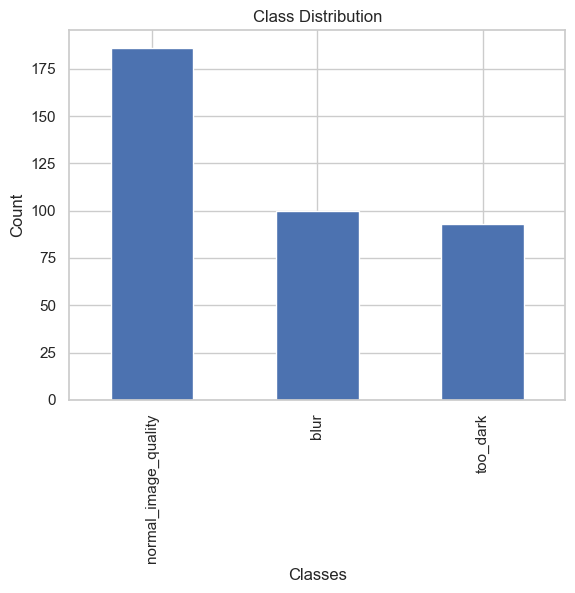

In [78]:
# agreement sample analysis

# class distribution in the ground truth
df_clean['ground_truth'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()


In [79]:
#define model predictions based on the highest probability

df_clean['model_a_pred'] = df_clean[['model_a_too_dark', 'model_a_blur', 'model_a_normal_image_quality']].idxmax(axis=1).str.replace('model_a_', '')
df_clean['model_b_pred'] = df_clean[['model_b_too_dark', 'model_b_blur', 'model_b_normal_image_quality']].idxmax(axis=1).str.replace('model_b_', '')
df_clean

,image_url,labeller1_label,labeller2_label,model_a_too_dark,model_a_blur,model_a_normal_image_quality,model_b_too_dark,model_b_blur,model_b_normal_image_quality,agreement,ambiguous,prob_sum_a,prob_sum_b,ground_truth,model_a_pred,model_b_pred
0,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/4e58f149-1c8d-4159-9e6f-614dec04cced.jpg,normal,normal,0.004,0.871,0.301,0.008,0.005,0.986,True,False,1.176,0.999,normal_image_quality,blur,normal_image_quality
1,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/35f6e863-9728-448e-8ce2-d94d2d24b028.jpg,normal,normal,0.007,0.010,0.994,0.008,0.011,0.989,True,False,1.011,1.009,normal_image_quality,normal_image_quality,normal_image_quality
2,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/9453c99f-a213-46f5-b58e-601aa7a69cfe.jpg,normal,normal,0.004,0.111,0.933,0.006,0.004,0.991,True,False,1.048,1.000,normal_image_quality,normal_image_quality,normal_image_quality
3,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/c8d43ad7-647c-4dda-89f8-b7af63815aa2.jpg,normal,normal,0.090,0.013,0.839,0.005,0.008,0.993,True,False,0.942,1.005,normal_image_quality,normal_image_quality,normal_image_quality
4,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/a58246ea-fc2d-4a8d-a0d8-f434251e5a96.jpg,normal,normal,0.007,0.008,0.994,0.007,0.012,0.991,True,False,1.009,1.010,normal_image_quality,normal_image_quality,normal_image_quality
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/0c4c1d96-d33e-485a-b19f-0159f52ac09d.jpg,too_dark,too_dark,0.997,0.005,0.005,0.995,0.010,0.009,True,False,1.007,1.014,too_dark,too_dark,too_dark
375,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/6a7bdde4-0d1f-4961-9fac-509f37e9b761.jpg,too_dark,too_dark,0.997,0.003,0.004,0.996,0.007,0.007,True,False,1.004,1.011,too_dark,too_dark,too_dark
376,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/f0380ad7-29af-4936-8660-0bd2a5057333.jpg,normal,normal,0.008,0.008,0.988,0.006,0.008,0.990,True,False,1.004,1.004,normal_image_quality,normal_image_quality,normal_image_quality
377,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/1d88ee21-253b-4668-bd08-0e95c02eb907.jpg,too_dark,too_dark,0.997,0.006,0.004,0.995,0.018,0.009,True,False,1.007,1.022,too_dark,too_dark,too_dark


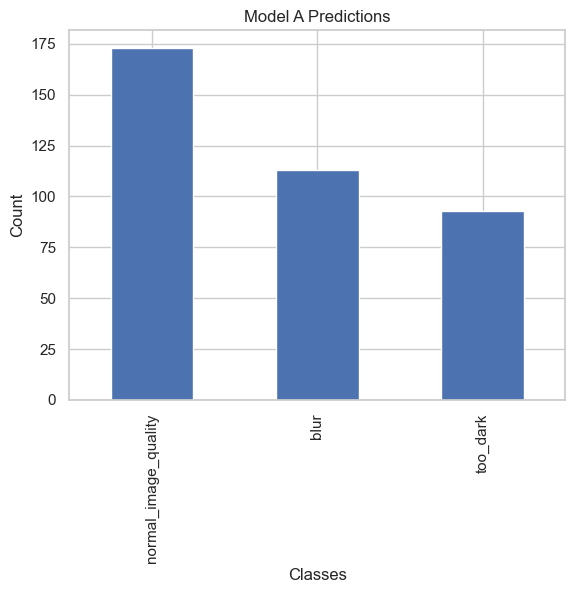

In [80]:
#plotting the model A predictions
df_clean['model_a_pred'].value_counts().plot(kind='bar', title='Model A Predictions')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

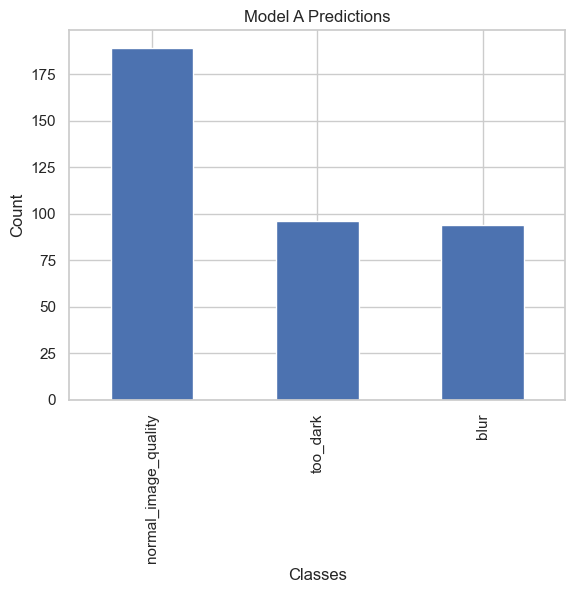

In [81]:
#plotting the model B predictions
df_clean['model_b_pred'].value_counts().plot(kind='bar', title='Model A Predictions')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

In [82]:
# Calculate Metrics for Model A and Model B

# print(classification_report(df_clean['ground_truth'], df_clean['model_a_pred'], target_names=['too_dark', 'blur', 'normal']))
# print(classification_report(df_clean['ground_truth'], df_clean['model_b_pred'], target_names=['too_dark', 'blur', 'normal'])) 

print("Classification Report for Model A")
print(classification_report(df_clean['ground_truth'], df_clean['model_a_pred'], target_names=['too_dark', 'blur', 'normal_image_quality']))

print("\nClassification Report for Model B")
print(classification_report(df_clean['ground_truth'], df_clean['model_b_pred'], target_names=['too_dark', 'blur', 'normal_image_quality']))

Classification Report for Model A
                      precision    recall  f1-score   support

            too_dark       0.87      0.98      0.92       100
                blur       0.99      0.92      0.96       186
normal_image_quality       0.95      0.95      0.95        93

            accuracy                           0.94       379
           macro avg       0.94      0.95      0.94       379
        weighted avg       0.95      0.94      0.95       379


Classification Report for Model B
                      precision    recall  f1-score   support

            too_dark       0.99      0.93      0.96       100
                blur       0.98      1.00      0.99       186
normal_image_quality       0.96      0.99      0.97        93

            accuracy                           0.98       379
           macro avg       0.98      0.97      0.97       379
        weighted avg       0.98      0.98      0.98       379



Here are the key observations from the classification reports:

**Model A:**
- Overall accuracy is 94%.
- "too_dark": High precision (0.87) and very high recall (0.98), meaning most "too_dark" images are correctly identified, but there are some false positives.
- "blur": Very high precision (0.99) and high recall (0.92), so almost all predicted "blur" images are correct, but a few actual "blur" images are missed.
- "normal_image_quality": Both precision and recall are high (0.95), indicating balanced and reliable performance for this class.
- Macro and weighted averages are both around 0.94–0.95, showing consistent performance across classes.

**Model B:**
- Overall accuracy is 98%, higher than Model A.
- "too_dark": Extremely high precision (0.99) and high recall (0.93), so almost all predicted "too_dark" images are correct, but a few actual "too_dark" images are missed.
- "blur": Both precision and recall are extremely high (0.98 and 1.00), meaning almost perfect identification of "blur" images.
- "normal_image_quality": Precision (0.96) and recall (0.99) are both very high, indicating excellent performance.
- Macro and weighted averages are both 0.97–0.98, showing very strong and balanced performance across all classes.

**Summary:**
- Model B outperforms Model A in all metrics, especially in overall accuracy and the "blur" and "normal_image_quality" classes.
- Both models perform well, but Model B is more consistent and reliable across all classes, with fewer misclassifications.

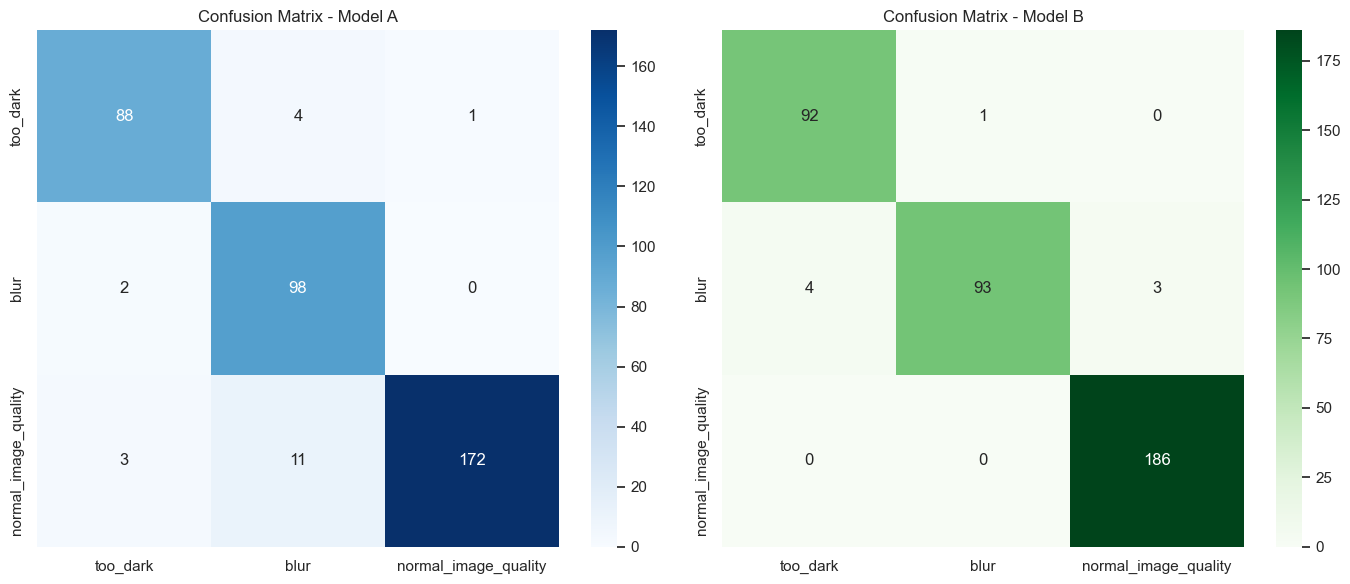

In [83]:
cm_A = confusion_matrix(df_clean['ground_truth'], df_clean['model_a_pred'], labels=['too_dark', 'blur', 'normal_image_quality'])
cm_B = confusion_matrix(df_clean['ground_truth'], df_clean['model_b_pred'], labels=['too_dark', 'blur', 'normal_image_quality'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_A, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['too_dark', 'blur', 'normal_image_quality'],
            yticklabels=['too_dark', 'blur', 'normal_image_quality'])
axes[0].set_title("Confusion Matrix - Model A")

sns.heatmap(cm_B, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['too_dark', 'blur', 'normal_image_quality'],
            yticklabels=['too_dark', 'blur', 'normal_image_quality'])
axes[1].set_title("Confusion Matrix - Model B")

plt.tight_layout()
plt.show()


Summary:

| Actual \ Predicted         | too\_dark | blur | normal\_image\_quality | Total Actual |
| -------------------------- | --------- | ---- | ---------------------- | ------------ |
| **too\_dark**              | A: 88     | 4    | 1                      | 93           |
|                            | B: 92     | 1    | 0                      |              |
| **blur**                   | A: 2      | 98   | 0                      | 100          |
|                            | B: 4      | 93   | 3                      |              |
| **normal\_image\_quality** | A: 3      | 11   | 172                    | 186          |
|                            | B: 0      | 0    | 186                    |              |


Model A Summary :

✅ Correct predictions:
88 too_dark correctly classified

98 blur correctly classified

172 normal_image_quality correctly classified

❌ Misclassifications:
4 too_dark → blur

1 too_dark → normal

2 blur → too_dark

3 normal → too_dark

11 normal → blur

🧠 Insights:
Solid performance overall across all three classes

Some spillover from normal → blur (could cause unnecessary retakes)

Minor confusion between too_dark and blur

Slightly underdetects normal images — can reduce user trust in good submissions


Model B Summary:

✅ Correct predictions:
92 too_dark correctly classified

93 blur correctly classified

186 normal_image_quality correctly classified

❌ Misclassifications:
1 too_dark → blur

4 blur → too_dark

3 blur → normal

0 normal misclassified

🧠 Insights:
Perfect classification of normal images (huge business benefit)

Lower misclassification rate overall than Model A

Slight drop in blur recall, but better handling of too_dark and normal

Model B appears more confident and cleaner in its predictions

## Confidence analysis:

In [84]:
#flag whether each model’s prediction was correct or incorrect
df_clean['model_a_correct'] = df_clean['model_a_pred'] == df_clean['ground_truth']
df_clean['model_b_correct'] = df_clean['model_b_pred'] == df_clean['ground_truth']


In [85]:
# Model A's confidence for its predicted class
df_clean['model_a_confidence'] = df_clean[['model_a_too_dark', 'model_a_blur', 'model_a_normal_image_quality']].max(axis=1)

# Model B's confidence for its predicted class
df_clean['model_b_confidence'] = df_clean[['model_b_too_dark', 'model_b_blur', 'model_b_normal_image_quality']].max(axis=1)

In [86]:
# Model A
model_a_stats = df_clean.groupby('model_a_correct')['model_a_confidence'].mean().reset_index()
model_a_stats.columns = ['is_correct', 'mean_confidence_model_a']

# Model B
model_b_stats = df_clean.groupby('model_b_correct')['model_b_confidence'].mean().reset_index()
model_b_stats.columns = ['is_correct', 'mean_confidence_model_b']

print("Model A Confidence Analysis:")
print(model_a_stats)
print("\nModel B Confidence Analysis:")
print(model_b_stats)

Model A Confidence Analysis:
   is_correct  mean_confidence_model_a
0       False                    0.839
1        True                    0.962

Model B Confidence Analysis:
   is_correct  mean_confidence_model_b
0       False                    0.911
1        True                    0.991


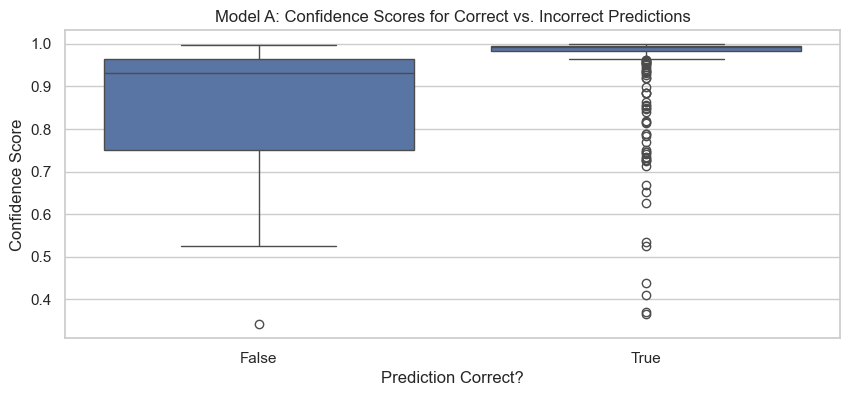

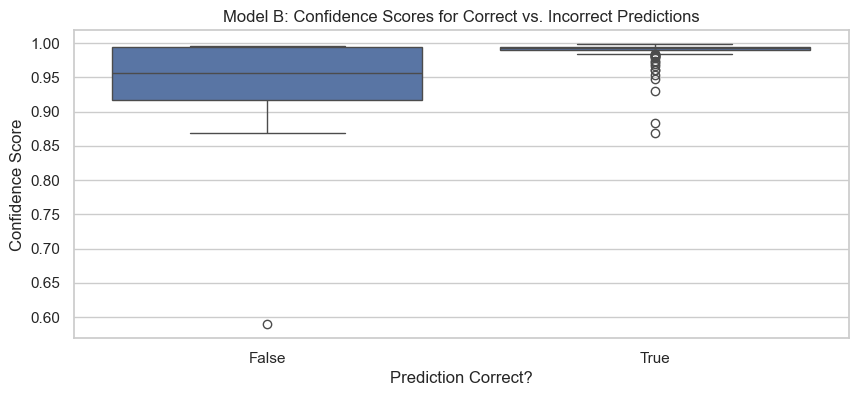

In [87]:
# Model A
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_clean, x='model_a_correct', y='model_a_confidence')
plt.title("Model A: Confidence Scores for Correct vs. Incorrect Predictions")
plt.xlabel("Prediction Correct?")
plt.ylabel("Confidence Score")
plt.show()

# Model B
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_clean, x='model_b_correct', y='model_b_confidence')
plt.title("Model B: Confidence Scores for Correct vs. Incorrect Predictions")
plt.xlabel("Prediction Correct?")
plt.ylabel("Confidence Score")
plt.show()

### Analysisng disagreement between models

In [91]:
df['model_a_pred'] = df[['model_a_too_dark', 'model_a_blur', 'model_a_normal_image_quality']].idxmax(axis=1).str.replace('model_a_', '')
df['model_b_pred'] = df[['model_b_too_dark', 'model_b_blur', 'model_b_normal_image_quality']].idxmax(axis=1).str.replace('model_b_', '')
disagreements = df[df['model_a_pred'] != df['model_b_pred']]
print(f"Found {len(disagreements)} edge cases where models disagree.")


Found 81 edge cases where models disagree.


In [96]:
# Categorize edge cases
disagreements['disagreement_type'] = disagreements.apply(
    lambda x: f"A:normal vs B:{x['model_b_pred']}" 
              if x['model_a_pred'] == 'normal_image_quality' 
              else f"A:{x['model_a_pred']} vs B:normal", 
    axis=1
)

# Count disagreement types
print(disagreements['disagreement_type'].value_counts())

disagreement_type
A:blur vs B:normal        60
A:too_dark vs B:normal    17
A:normal vs B:too_dark     4
Name: count, dtype: int64
